In [1]:
import random
from itertools import chain
from collections import defaultdict

import tskit
import pyslim
import pandas
import numpy
import matplotlib.pyplot as plt

from IPython.display import display, SVG

In [2]:
populations = pandas.read_table("model/populations.tsv")
populations

,pop,parent,N,tsplit_gen,tsplit_orig,tremove_gen,tremove_orig,pop_id,parent_id
0,NEA,ancestor,1000,1,600000,18834,35000,0,-1
1,AFR,ancestor,10000,1,600000,-1,-1,1,-1
2,EUR1,AFR,5000,17668,70000,-1,-1,2,1
3,EUR2,EUR1,5000,18501,45000,-1,-1,3,2


In [3]:
ts = pyslim.load("results/output_ts.trees")
ts

Get nodes (chromosomes) of remembered individuals:

In [4]:
remembered_nodes = list(chain.from_iterable(
    ind.nodes for ind in ts.individuals()
    if ind.flags & pyslim.INDIVIDUAL_REMEMBERED
))

Simplify the tree sequence to only those individuals:

In [5]:
ts = ts.simplify(remembered_nodes)

In [6]:
ts

Extract only a subset of all nodes from all populations for easier plotting of trees:

In [7]:
ts.tables.populations

id,metadata
0,"{'slim_id': 0, 'selfing_fraction': 0.0, 'female_cloning_fraction': ..."
1,"{'slim_id': 1, 'selfing_fraction': 0.0, 'female_cloning_fraction': ..."
2,"{'slim_id': 2, 'selfing_fraction': 0.0, 'female_cloning_fraction': ..."
3,"{'slim_id': 3, 'selfing_fraction': 0.0, 'female_cloning_fraction': ..."


In [9]:
neand_id = 0

In [19]:
neand_nodes = list(ts.samples(population=neand_id))

In [20]:
amh_nodes = list(chain.from_iterable(
    random.sample(list(ts.samples(population=pop_id)), 10)
    for pop_id in range(1, ts.num_populations)
))

In [21]:
subset_nodes = neand_nodes + amh_nodes

In [22]:
ts_small = ts.simplify(subset_nodes)

In [23]:
tree = ts_small.first()
tree

In [24]:
styles = []
# Create a style for each population, programmatically (or just type the string by hand)
for colour, p in zip(['red', 'green', 'blue', "orange"], ts_small.populations()):
    # target the symbols only (class "sym")
    s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
    styles.append(s)
    name = populations.query(f"pop_id == {p.id}")["pop"].values[0]
    print(f'"{s}" applies to nodes from population {name} (id {p.id})')
css_string = " ".join(styles)
print(f'CSS string applied:\n    "{css_string}"')

".node.p0 > .sym {fill: red}" applies to nodes from population NEA (id 0)
".node.p1 > .sym {fill: green}" applies to nodes from population AFR (id 1)
".node.p2 > .sym {fill: blue}" applies to nodes from population EUR1 (id 2)
".node.p3 > .sym {fill: orange}" applies to nodes from population EUR2 (id 3)
CSS string applied:
    ".node.p0 > .sym {fill: red} .node.p1 > .sym {fill: green} .node.p2 > .sym {fill: blue} .node.p3 > .sym {fill: orange}"


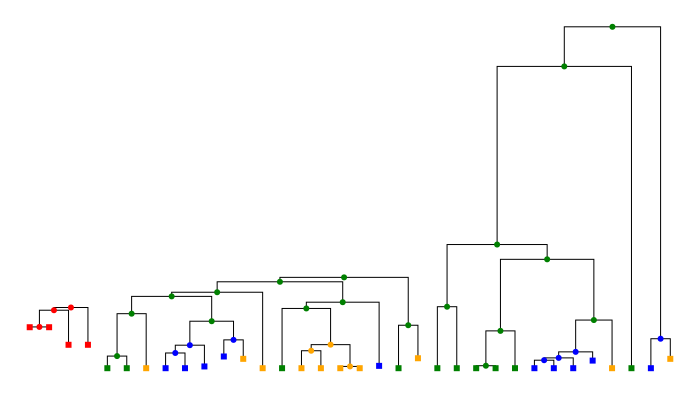

In [25]:
display(SVG(tree.draw_svg(size=(700, 400), node_labels={}, style=css_string)))

Iterate over all trees and detect those which indicate Neanderthal introgression into Eurasians:

In [27]:
def detect_introgressed(tree, neand_id):
    start, end = tree.interval

    admixed_list = []
    for root in tree.roots:
        # is the current root rooted in a Neanderthal population?
        if tree.population(root) == neand_id:
            # if it is, collect all non-Neanderthal nodes under this root
            # (these are Eurasians carrying Neanderthal introgression at this locus)
            admixed = [node for node in tree.leaves(root)
                       if tree.population(node) != neand_id]
            admixed_list.extend(admixed)

#    return (start, end), admixed_list
    return admixed_list

In [28]:
introgressed_segments = []

for tree in ts_small.trees():
    result = detect_introgressed(tree, neand_id)
    start, end = tree.interval
    introgressed_segments.append((start, end, result))

In [29]:
segments = pandas.DataFrame(introgressed_segments, columns=["start", "end", "node"]) \
    .explode("node") \
    .reset_index(drop=True) \
    .dropna()

In [32]:
populations

,pop,parent,N,tsplit_gen,tsplit_orig,tremove_gen,tremove_orig,pop_id,parent_id
0,NEA,ancestor,1000,1,600000,18834,35000,0,-1
1,AFR,ancestor,10000,1,600000,-1,-1,1,-1
2,EUR1,AFR,5000,17668,70000,-1,-1,2,1
3,EUR2,EUR1,5000,18501,45000,-1,-1,3,2


True archaic ancestry on EUR chromosome ID #14: 2.14%
True archaic ancestry on EUR chromosome ID #15: 2.85%
True archaic ancestry on EUR chromosome ID #16: 2.27%
True archaic ancestry on EUR chromosome ID #17: 2.30%
True archaic ancestry on EUR chromosome ID #18: 3.42%
True archaic ancestry on EUR chromosome ID #19: 2.10%
True archaic ancestry on EUR chromosome ID #20: 3.37%
True archaic ancestry on EUR chromosome ID #21: 2.23%
True archaic ancestry on EUR chromosome ID #22: 2.88%
True archaic ancestry on EUR chromosome ID #23: 3.28%
True archaic ancestry on EUR chromosome ID #24: 3.18%
True archaic ancestry on EUR chromosome ID #25: 3.69%
True archaic ancestry on EUR chromosome ID #26: 3.51%
True archaic ancestry on EUR chromosome ID #27: 4.09%
True archaic ancestry on EUR chromosome ID #28: 4.72%
True archaic ancestry on EUR chromosome ID #29: 4.10%
True archaic ancestry on EUR chromosome ID #30: 3.24%
True archaic ancestry on EUR chromosome ID #31: 3.09%
True archaic ancestry on EUR

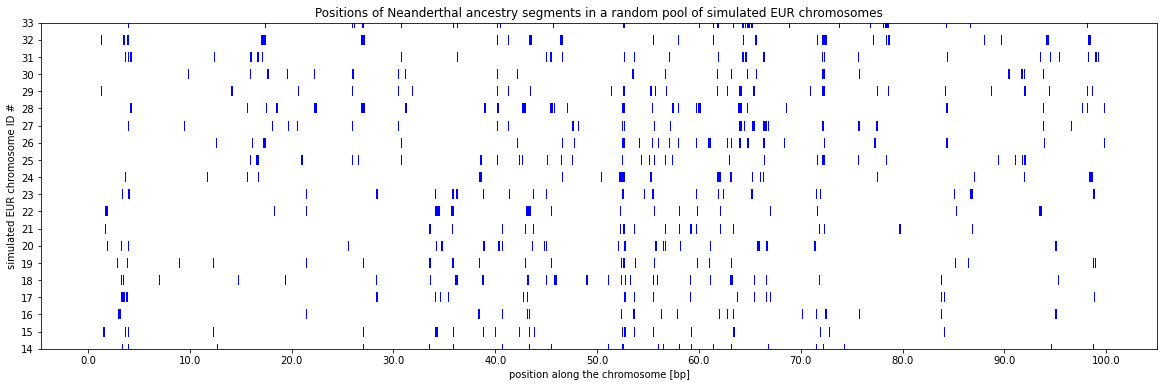

In [54]:
nodes = sorted(segments.node.unique())

fig, ax = plt.subplots(figsize=(20, 6))

ax.set_title("Positions of Neanderthal ancestry segments in a random pool of simulated EUR chromosomes")
ax.set_ylabel("simulated EUR chromosome ID #")
ax.set_xlabel("position along the chromosome [bp]")

ax.set_ylim(min(nodes), max(nodes))
ax.set_yticks(nodes)
ax.set_yticklabels(nodes)

positions = numpy.linspace(0, 100e6, 11)
ax.set_xticks(positions)
ax.set_xticklabels([f"{i/1e6}" for i in positions])

for node in nodes:
    node_segments = segments.query(f"node == {node}")

    for segment in node_segments.itertuples():
        ax.hlines(y=node, xmin=segment.start, xmax=segment.end, linewidth=10, color='b')
    neand_proportion = (node_segments.end - node_segments.start).sum()/100e6

    print(f"True archaic ancestry on EUR chromosome ID #{node}: {100 * neand_proportion:.2f}%")

plt.show()